# APO Proposal for ASTR 581
### Tom Wagg

This notebook was created using all of the helpful information from [this one](https://nbviewer.org/github/growth-astro/growth-school-2020/blob/master/observing_preparation/observing_prep.ipynb) (suggested by Andy Tzanidakis!)

In [1]:
import numpy as np
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, Angle
from astropy.coordinates import EarthLocation
import pytz
from astroplan import Observer, FixedTarget
from astropy.utils.iers import conf
conf.auto_max_age = None
from astropy.coordinates import get_sun, get_moon, get_body
from astroplan import moon_illumination
from matplotlib import dates

import matplotlib.pyplot as plt
from astroplan.plots import plot_sky, plot_airmass
from astroplan import EclipsingSystem
from astroplan import (PrimaryEclipseConstraint, is_event_observable,
                       AtNightConstraint, AltitudeConstraint, LocalTimeConstraint, AirmassConstraint)

from astroplan import download_IERS_A 
download_IERS_A()

from astroquery.ipac.nexsci.nasa_exoplanet_archive import NasaExoplanetArchive

In [2]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)
plt.style.use('dark_background')

# General Plan

I'm going to start the project with Eric soon about looking into the radius valley between rocky and gassy planets using multi-transiting systems. So he's given me a couple of these systems to investigate and I'm going to see whether I can perhaps image the transit or get spectroscopy (during or not during a transit).

# Assess which of the systems can actually be observed during the trip

In [3]:
location = EarthLocation.of_site("Apache Point Observatory")
apo = Observer(location=location, timezone='US/Mountain',
               name="APO", description="Apache Point Observatory")

In [4]:
systems = [
    {
        "name": "K2-3",
        "ra": Angle("11h29m20.49s", unit=u.hourangle),
        "dec": Angle("-01d27m18.49s", unit=u.hourangle),
        "distance": 44.07270 * u.pc,
        "link": "https://exoplanetarchive.ipac.caltech.edu/overview/K2-3%20d#planet_K2-3-d_collapsible",
    },
    {
        "name": "HD 260655",
        "ra":  99.2958 * u.deg,
        "dec": 17.5647 * u.deg,
        "distance": 44.07270 * u.pc,
        "link": "http://www.exoplanetkyoto.org/exohtml/HD_260655_b.html"
    },
    {
        "name": "TOI-1238",
        "ra": Angle("13 25 32.00", unit=u.hourangle),
        "dec": Angle("+68 50 10.00", unit=u.degree),
        "distance":  70.64 * u.pc,
        "link": "http://www.openexoplanetcatalogue.com/planet/TOI-1238%20b/"
    },
    {
        "name": "K2-138",
        "ra": Angle("23h15m47.77s", unit=u.hourangle),
        "dec": Angle("-10d50m59.06s", unit=u.hourangle),
        "distance": 202.585 * u.pc,
        "link": "https://exoplanetarchive.ipac.caltech.edu/overview/k2-138"
    },
    {
        "name": "Kepler-1972",
        "ra": Angle("19h13m34.87s", unit=u.hourangle),
        "dec": Angle("+39d52m21.02s", unit=u.hourangle),
        "distance": 287.389 * u.pc,
        "link": "https://exoplanetarchive.ipac.caltech.edu/overview/Kepler-1972"
    },
]

# convert to astropy coords
target_coords = [SkyCoord(ra=system["ra"], dec=system["dec"], distance=system["distance"]) for system in systems]

### Airmass plots for each of the observing nights

Note for the much of the code below I modified `astroplan`'s source code for `plot_airmass` because it had some bugs

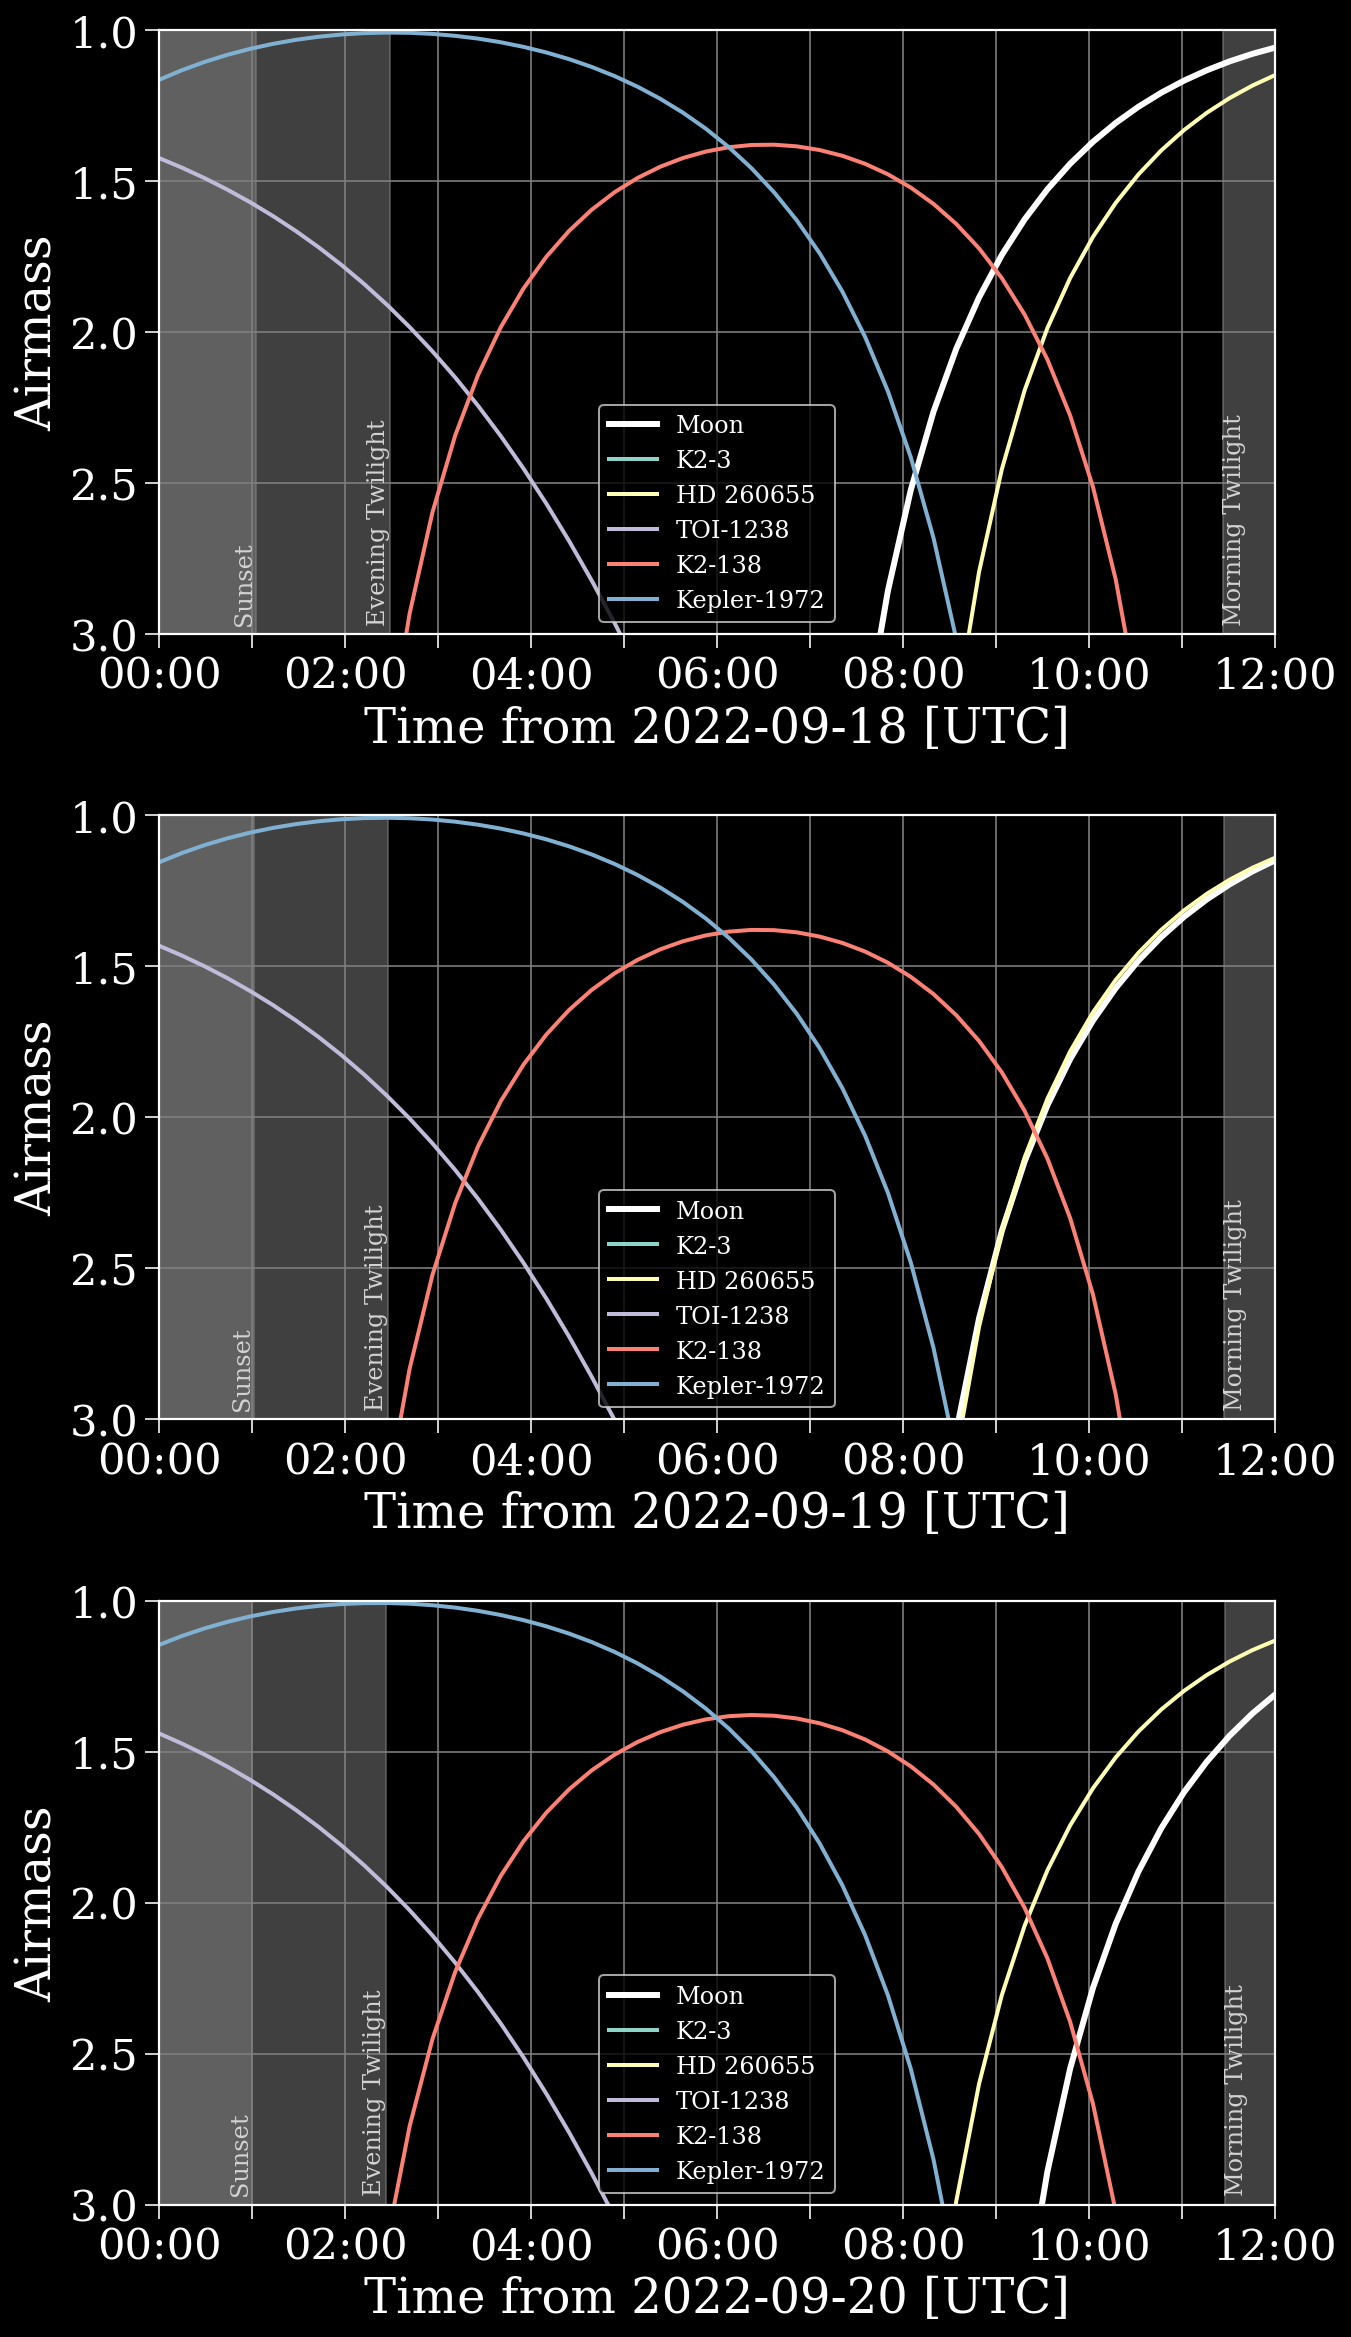

In [106]:
fig, axes = plt.subplots(3, 1, figsize=(10, 20))

fig.subplots_adjust(hspace=0.3)

for day, ax in zip([18, 19, 20], axes):

    obs_time = Time(f"2022-09-{day}")
    sunset = apo.sun_set_time(obs_time, which='nearest')
    eve_twil = apo.twilight_evening_astronomical(obs_time, which='nearest')
    midnight = apo.midnight(obs_time, which='next')
    morn_twil = apo.twilight_morning_astronomical(obs_time, which='next')
    sunrise = apo.sun_rise_time(obs_time, which='next')

    t_start = Time(f"2022-09-{day} 00:00:00")
    t_end = Time(f"2022-09-{day} 12:00:00")
    
    # space observation times during dark time
    t_observe = t_start + (t_end - t_start) * np.linspace(0.0, 1.0, 50)
    
    # work out where the moon is and plot it
    moon = get_moon(t_observe)
    moon_airmass = apo.altaz(t_observe, moon).secz
    ax.plot(t_observe[moon_airmass >= 1].plot_date, moon_airmass[moon_airmass >= 1],
            label="Moon", color="white", lw=3)

    # plot each system
    for target, system in zip(target_coords, systems):

        if hasattr(t_observe, 'utcoffset') and use_local_tz:
            tzoffset = t_observe.utcoffset()
            tzname = t_observe.tzname()
            tzinfo = t_observe.tzinfo
        else:
            tzoffset = 0 * u.day
            tzname = 'UTC'
            tzinfo = None

        timetoplot = t_observe + tzoffset
        airmass = apo.altaz(t_observe, target).secz

        ax.plot(timetoplot[airmass >= 1].plot_date, airmass[airmass >= 1], label=system["name"], lw=2)
    
    ax.set_ylim(3, 1)
    ax.grid(color="grey")

    ax.axvspan(t_start.plot_date, sunset.plot_date, color="grey", alpha=0.5)
    ax.axvspan(t_start.plot_date, eve_twil.plot_date, color="grey", alpha=0.5)
    
    ax.annotate("Sunset", xy=(sunset.plot_date, 2.97), ha="right", va="bottom", rotation=90, fontsize=0.5*fs, color="lightgrey")
    ax.annotate("Evening Twilight", xy=(eve_twil.plot_date, 2.97), ha="right", va="bottom", rotation=90, fontsize=0.5*fs, color="lightgrey")
    ax.annotate("Morning Twilight", xy=(morn_twil.plot_date, 2.97), ha="left", va="bottom", rotation=90, fontsize=0.5*fs, color="lightgrey")
    
    ax.axvspan(morn_twil.plot_date, t_end.plot_date, color="grey", alpha=0.5)
    ax.axvspan(sunrise.plot_date, t_end.plot_date, color="grey", alpha=0.5)


    ax.legend(fontsize=0.7*fs, loc="upper left")
    
    ax.set_xlim([t_start.plot_date, t_end.plot_date])
    ax.set_xticks([Time(f"2022-09-{day} {i:02d}:00:00").plot_date for i in range(0, 12 + 1)])
    ax.set_xticklabels([f'{Time(f"2022-09-{day} {i:02d}:00:00").ymdhms[3]:02d}:00' if i % 2 == 0 else "" for i in range(0, 12 + 1)])

    ax.legend(fontsize=0.5*fs)

    ax.set_ylabel("Airmass")
    ax.set_xlabel("Time from {0} [{1}]".format(min(timetoplot).datetime.date(), tzname))

plt.savefig("../figures/potential_systems.pdf", format="pdf", bbox_inches="tight")

plt.show()

## Conclusions

Based on this it seems like our good targets are Kepler-1972 and K2-138 (the rest aren't really below 1.5 airmass for very long - HD 260655 is marginal but the moon will probably mess it up).

# Okay, but are they transiting?

In [6]:
k1972b = EclipsingSystem(primary_eclipse_time=Time(2454944.8999, format="jd"),
                           orbital_period=7.54425 * u.day, duration=1.9 * u.hour,
                           name='kepler-1972b')
print(k1972b.next_primary_eclipse_time(Time("2022-09-18")))

['2022-09-18 14:50:05.160']


In [7]:
k1972c = EclipsingSystem(primary_eclipse_time=Time(2454952.800, format="jd"),
                           orbital_period=11.3295 * u.day, duration=1.7 * u.hour,
                           name='kepler-1972c')
print(k1972c.next_primary_eclipse_time(Time("2022-09-18")))

['2022-09-24 15:27:18.600']


#### Damn

### We can use astroquery to get the planets I've realised

In [8]:
results = NasaExoplanetArchive.query_object("K2-138")

UnitTypeError("MaskedQuantity instances require normal units, not <class 'astropy.units.function.logarithmic.DexUnit'> instances.") [astropy.table.table]
UnitTypeError("MaskedQuantity instances require normal units, not <class 'astropy.units.function.logarithmic.DexUnit'> instances.") [astropy.table.table]
UnitTypeError("MaskedQuantity instances require normal units, not <class 'astropy.units.function.logarithmic.DexUnit'> instances.") [astropy.table.table]
UnitTypeError("MaskedQuantity instances require normal units, not <class 'astropy.units.function.logarithmic.DexUnit'> instances.") [astropy.table.table]
UnitTypeError("MaskedQuantity instances require normal units, not <class 'astropy.units.function.logarithmic.DexUnit'> instances.") [astropy.table.table]
UnitTypeError("MaskedQuantity instances require normal units, not <class 'astropy.units.function.logarithmic.DexUnit'> instances.") [astropy.table.table]


Only grab the ones from the latest paper

In [9]:
latest_k2_138_planets = results[results["releasedate"] == "2021-03-04"]

In [10]:
k2_138_transits = [None for i in range(len(latest_k2_138_planets))]
for i in range(len(latest_k2_138_planets)):
    k2_138_transits[i] = EclipsingSystem(primary_eclipse_time=Time(latest_k2_138_planets["pl_tranmid"][i].value, format="jd"),
                                         orbital_period=latest_k2_138_planets["pl_orbper"][i].value * u.day,
                                         duration=latest_k2_138_planets["pl_trandur"][i].value * u.hour,
                                         name=latest_k2_138_planets["pl_name"][i])

In [104]:
# start at the first night
obs_time = Time(f"2022-09-18")

# constrain that it needs to be night, above the horizon by 30deg and airmass below 1.5
constraints = [AtNightConstraint.twilight_civil(),
               AltitudeConstraint(min=30*u.deg),
               AirmassConstraint(3)]

observable_transits = []
for i in range(len(k2_138_transits)):
    # get the next transit times
    times = k2_138_transits[i].next_primary_eclipse_time(obs_time, n_eclipses=10)
    
    # take only those in the observing nights
    times = times[times < Time("2022-09-21")]
    if len(times) > 0:
        if np.ravel(is_event_observable(constraints, apo, target, times=times)).any():
            observable_transits.append({
                "name": k2_138_transits[i].name,
                "mid": times[0],
                "duration": k2_138_transits[i].duration
            })

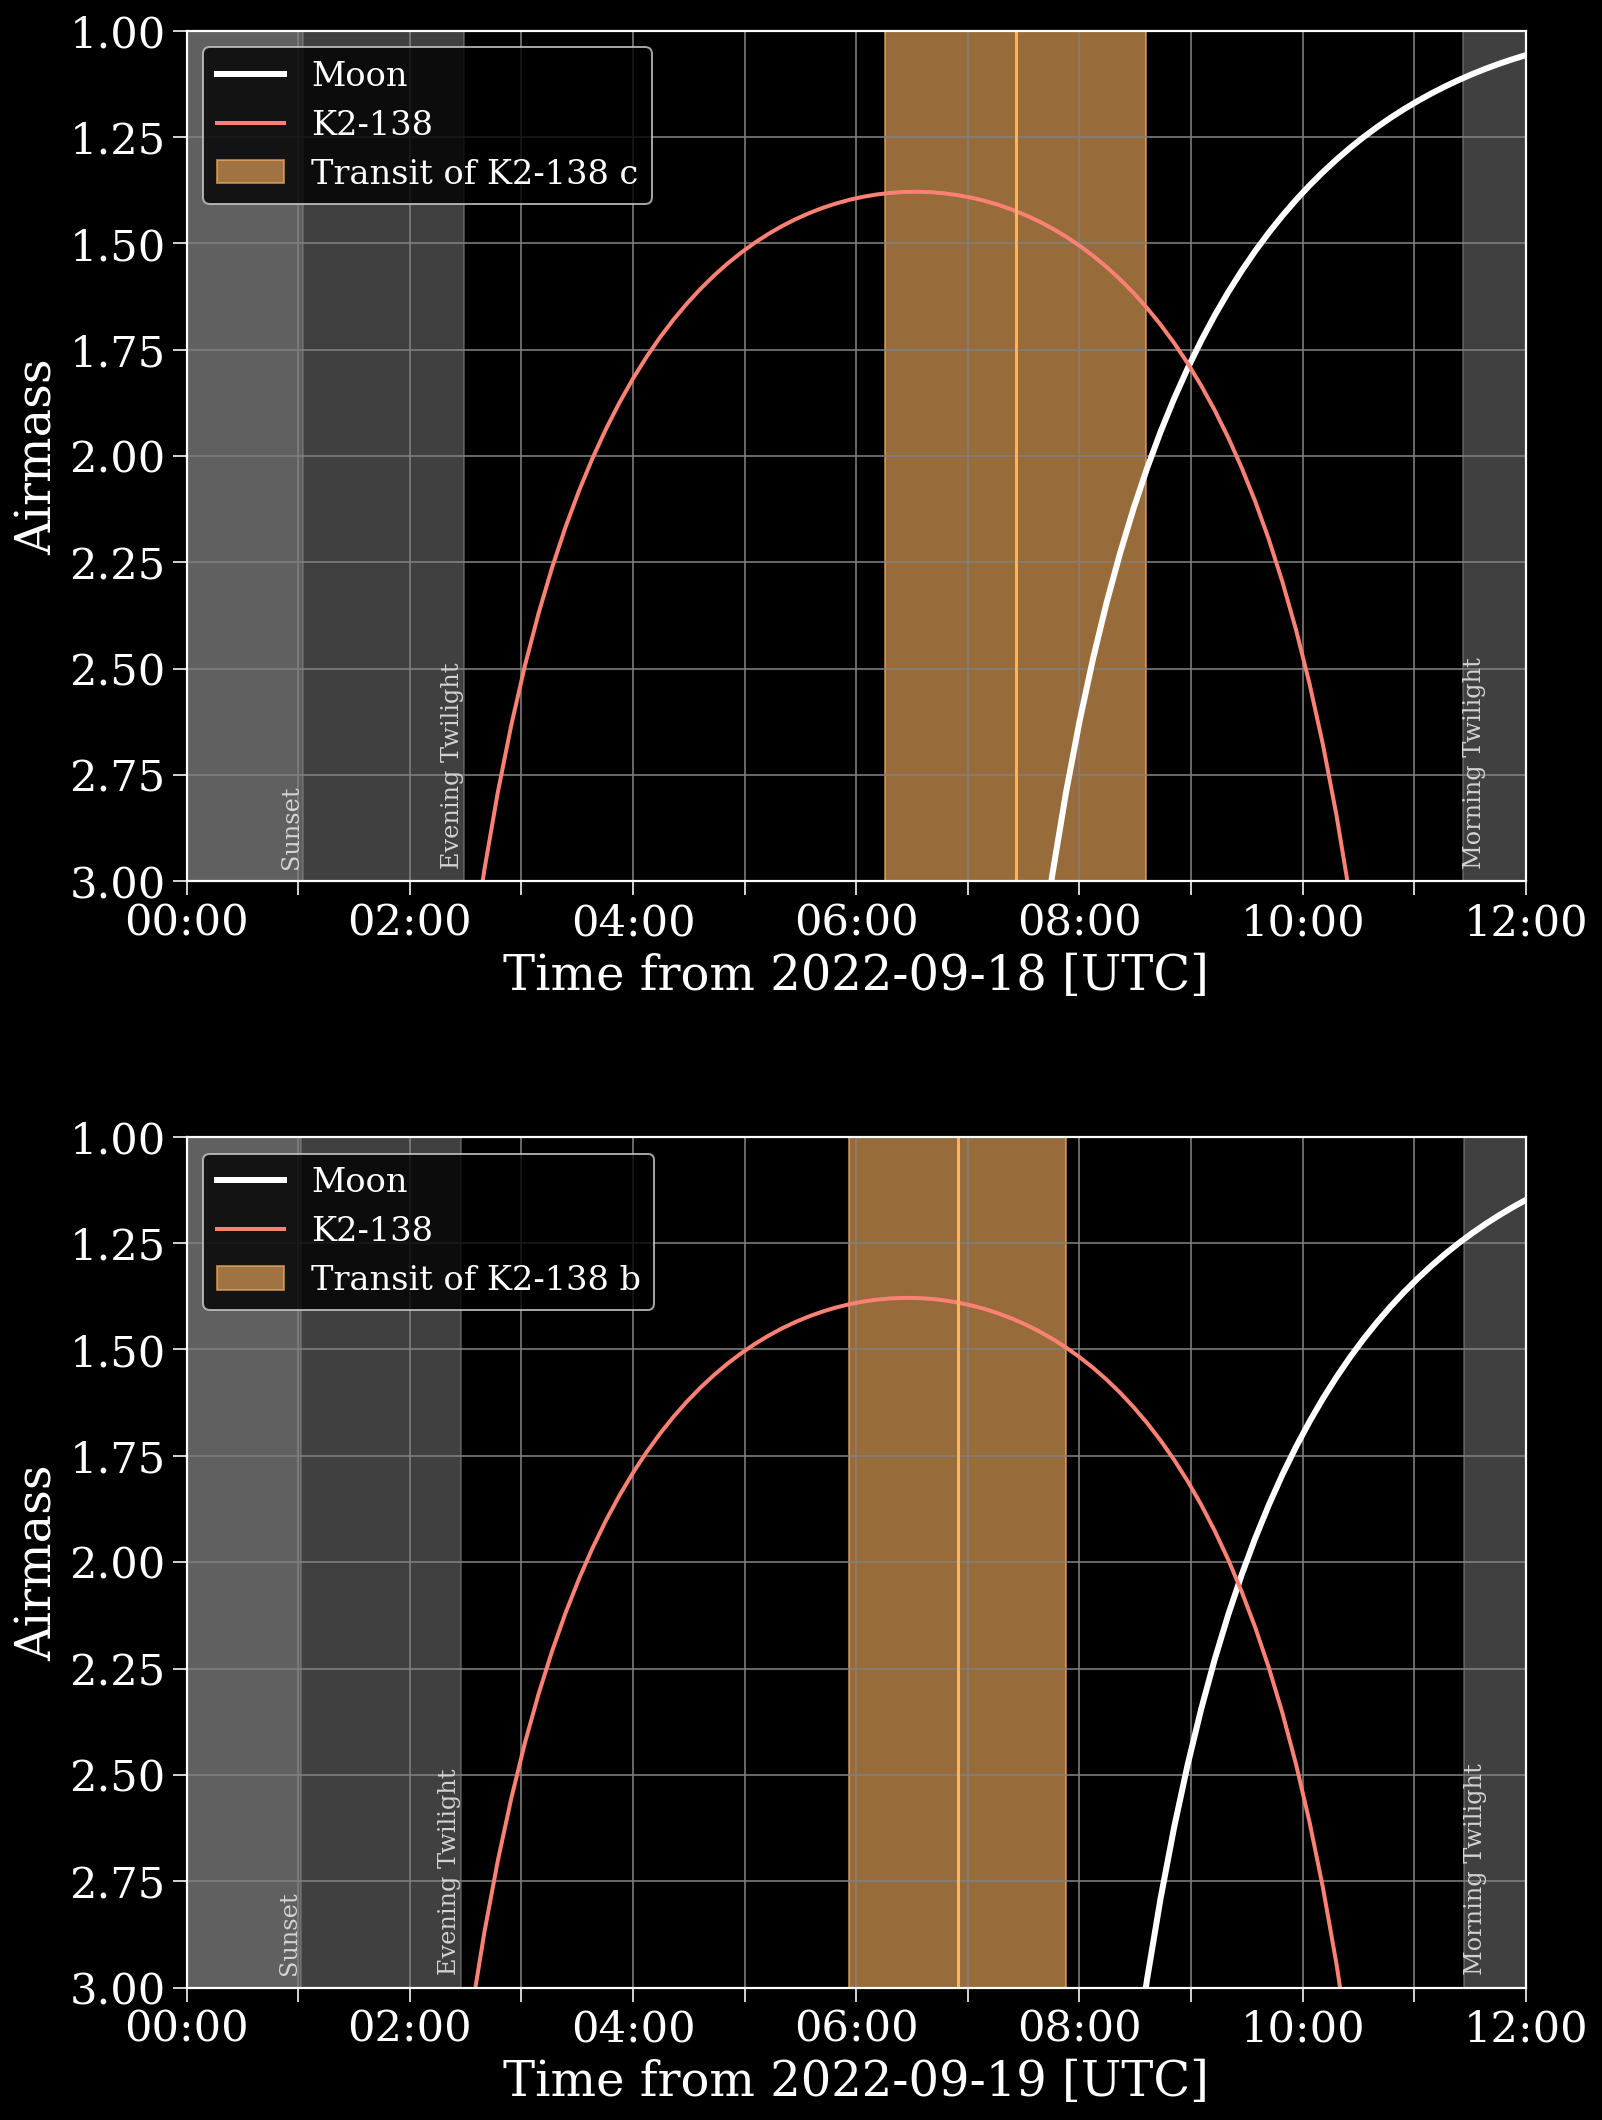

In [105]:
# plot em up

fig, axes = plt.subplots(2, 1, figsize=(12, 18))
fig.subplots_adjust(hspace=0.3)

target, system = target_coords[-2], systems[-2]

for day, ax in zip([18, 19], axes):
    obs_time = Time(f"2022-09-{day}")
    sunset = apo.sun_set_time(obs_time, which='nearest')
    eve_twil = apo.twilight_evening_astronomical(obs_time, which='nearest')
    midnight = apo.midnight(obs_time, which='next')
    morn_twil = apo.twilight_morning_astronomical(obs_time, which='next')
    sunrise = apo.sun_rise_time(obs_time, which='next')

    t_start = Time(f"2022-09-{day} 00:00:00")
    t_end = Time(f"2022-09-{day} 12:00:00")
    t_observe = t_start + (t_end - t_start) * np.linspace(0.0, 1.0, 100)
    
    moon = get_moon(t_observe)
    moon_airmass = apo.altaz(t_observe, moon).secz
    
    ax.plot(t_observe[moon_airmass >= 1].plot_date, moon_airmass[moon_airmass >= 1],
            label="Moon", color="white", lw=3)

    if hasattr(t_observe, 'utcoffset') and use_local_tz:
        tzoffset = t_observe.utcoffset()
        tzname = t_observe.tzname()
        tzinfo = t_observe.tzinfo
    else:
        tzoffset = 0 * u.day
        tzname = 'UTC'
        tzinfo = None

    timetoplot = t_observe + tzoffset
    airmass = apo.altaz(t_observe, target).secz

    ax.plot(timetoplot[airmass >= 1].plot_date, airmass[airmass >= 1], label=system["name"], lw=2, color="C3")
    
    for transit in observable_transits:
        if transit["mid"] < t_observe[-1] and transit["mid"] > t_observe[0]:
            ax.axvline(Time(transit["mid"]).plot_date, color="C5")
            ax.axvspan((Time(transit["mid"]) - (transit["duration"] / 2)).plot_date,
                       (Time(transit["mid"]) + (transit["duration"] / 2)).plot_date, color="C5",
                       alpha=0.6, label=f"Transit of {transit['name']}")
    
    ax.set_ylim(3, 1)
    ax.grid(color="grey");
    
    ax.axvspan(t_start.plot_date, sunset.plot_date, color="grey", alpha=0.5)
    ax.axvspan(t_start.plot_date, eve_twil.plot_date, color="grey", alpha=0.5)
    
    ax.annotate("Sunset", xy=(sunset.plot_date, 2.97), ha="right", va="bottom", rotation=90, fontsize=0.5*fs, color="lightgrey")
    ax.annotate("Evening Twilight", xy=(eve_twil.plot_date, 2.97), ha="right", va="bottom", rotation=90, fontsize=0.5*fs, color="lightgrey")
    ax.annotate("Morning Twilight", xy=(morn_twil.plot_date, 2.97), ha="left", va="bottom", rotation=90, fontsize=0.5*fs, color="lightgrey")
    
    ax.axvspan(morn_twil.plot_date, t_end.plot_date, color="grey", alpha=0.5)
    ax.axvspan(sunrise.plot_date, t_end.plot_date, color="grey", alpha=0.5)


    ax.legend(fontsize=0.7*fs, loc="upper left")
    
    ax.set_xlim([t_start.plot_date, t_end.plot_date])
    ax.set_xticks([Time(f"2022-09-{day} {i:02d}:00:00").plot_date for i in range(0, 12 + 1)])
    ax.set_xticklabels([f'{Time(f"2022-09-{day} {i:02d}:00:00").ymdhms[3]:02d}:00' if i % 2 == 0 else "" for i in range(0, 12 + 1)])

    ax.set_ylabel("Airmass")
    ax.set_xlabel("Time from {0} [{1}]".format(min(timetoplot).datetime.date(), tzname))
    
plt.savefig("../figures/observable_transits.pdf", format="pdf", bbox_inches="tight")

plt.show()

# What exposure time do we need for spectroscopy?

In [ ]:
import arcesetc
import astropy.units as u
arcesetc.signal_to_noise_to_exp_time(sptype="K1V", 
                                     wavelength=6562 * u.Angstrom,
                                     V=12.21,
                                     signal_to_noise=10).to(u.s)

In [ ]:
waves, flux, sptype, exp_time = arcesetc.reconstruct_order(sptype="K1V", wavelength=6562*u.Angstrom, V=12.21, exp_time=None,
                       signal_to_noise=3)

In [ ]:
plt.plot(waves,flux)

In [ ]:
arcesetc.available_sptypes()

In [ ]:
arcesetc.plot_order_sn(sptype="K1V", wavelength=6562*u.Angstrom, V=12.21, exp_time=None,
                       signal_to_noise=3)
arcesetc.plot_order_sn(sptype="K2V", wavelength=6562*u.Angstrom, V=12.21, exp_time=None,
                       signal_to_noise=3)